## **Building Multi-Agent Systems (MaS)**

If you've been following along with the notebooks, you're now ready to build enterprise-grade multi-agent systems (MaS). While orchestrating multiple agents might seem overwhelming, the key is to design and build strong, scalable single-agent solutions. These single agents form the backbone of any robust agent-based system, ensuring scalability, security, and reliability. We previously built enterprise-ready agents using Azure AI Agent Service.

In this notebook, we'll learn how to orchestrate our these single agents (cloud-managed via Azure AI Agent Service) by leveraging both the Semantic Kernel and AutoGen frameworks.

### **Before we start, let's double down on this key concept...**

#### **My Formula (and Mental Model) for building MaS**

**Multi-Agent Architecture** = Σ (Production-Ready Single Agents (with tools, memory, traceability, and isolated execution)) + Preferred Framework (Semantic Kernel, AutoGen, etc.)

Always start by breaking down the problem into its fundamental components. Identify the decoupled, modular functions that need to be developed, and then design and build the system from a high-level perspective down to the low-level details. In other words:

**First, build single agents:** Ensure that individual agents are scalable and work reliably for the identified specialized task. Leverage Azure AI Agent Service.

**Then, establish connections between agents, if needed:** Begin constructing inter-agent connections as add-on capabilities. This enables agents to collaborate on tasks—either by directly negotiating or by being indirectly guided toward a common goal. This approach will define your overall architecture and design pattern.

#### **Why Start with Single Agents?**

The `Azure AI Agent Service` makes it straightforward to design agents that are robust, context-aware, and capable of achieving specific goals autonomously. Once these agents successfully handle their tasks as singletons, you can gradually expand them into more complex multi-agent architectures.

**But how do we enable our agents to talk to each other?** In the human world, we might simply put people in the same room to converse naturally. Similarly, agents can be set up to interact and collaborate in virtual rooms, exchanging messages and forming the foundation for advanced, event-driven agent architectures. To achieve this, you can either build your code from scratch or leverage an existing framework. There are many options available, but at Microsoft, we are focusing on two open-source SDKs.

#### **Enable Agent Communication with the Power Duo: Semantic Kernel or AutoGen**

- **AutoGen:**  
  Ideal for creativity and experimentation, AutoGen serves as a state-of-the-art research SDK. It allows you to test new ideas, experiment with collaboration patterns, and push the boundaries of agent capabilities.

- **Semantic Kernel:**  
  Provides an enterprise-grade orchestration framework that supports seamless, non-breaking changes once your ideas are validated. It's designed for production-scale reliability, enabling teams to move quickly without sacrificing stability.
  
So it seems to make sense now, correct? We break down the problem, identify the different agent needs that must be part of the solution, and then focus on building a robust, reliable single-agent system first. Next, we use your preferred framework to orchestrate these single agents to resolve more complex tasks.

  
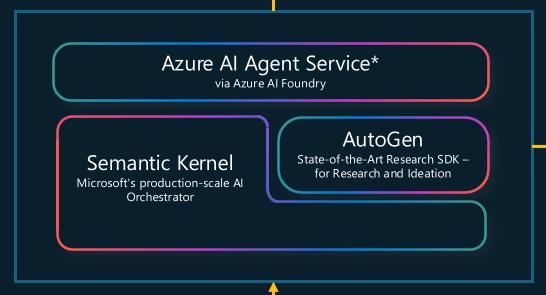


## **1. How-to create MaS with Autogen (Framework) + Azure AI Agent Service (Managed Agents)**

**Scenario**: Imagine you’re running a company that offers a comprehensive HR program. Your employees often ask about the program’s coverage details—“Does it include gym memberships? Yoga classes? Outdoor sports?” You want an automated assistant that can retrieve accurate information from your MongoDB database (or Cosmos DB using the MongoDB API) whenever employees ask these questions. Most of these questions have already been answered and stored in a Q&A dataset within Cosmos DB using the MongoDB core, and now you want an intelligent way to retrieve that data.

Because you want **accuracy and reliability**, you enlist a second agent. This second agent **double-checks** the first agent’s answer by searching Bing or other external sources. If everything matches up, the second agent responds with **“Approved!”** or offers corrective feedback if there’s a discrepancy. In short:

- **Mongo Execution Agent**: Receives the user request, queries the MongoDB database for relevant information, and returns it.  
- **Evaluation Agent**: Evaluate and is also capable to consults an external search engine (Bing) to verify whether the retrieved info is correct or up to date. If correct, it simply replies with **“Approved.”** If not, it asks for clarifications or corrections.

We are going to create these two single agents by leveraging the Azure AI agent service. If you want to learn more, please visit: `01-single-agent-with-azure-ai-agents.ipynb`

Finally, a **Multi-Agent Orchestrator** (in this example, a **round-robin loop from Autogen**) manages the conversation so that: (for a deep dive into Autogen, visit `03b-frameworks-intro-to-autogen-v2.ipynb`)

1. The user request goes to the **Mongo Execution Agent**.  
2. The result is then passed to the **Evaluation Agent**.  
3. If the content is verified, the system stops; otherwise, it can either provide feedback or re-try up to a certain limit.

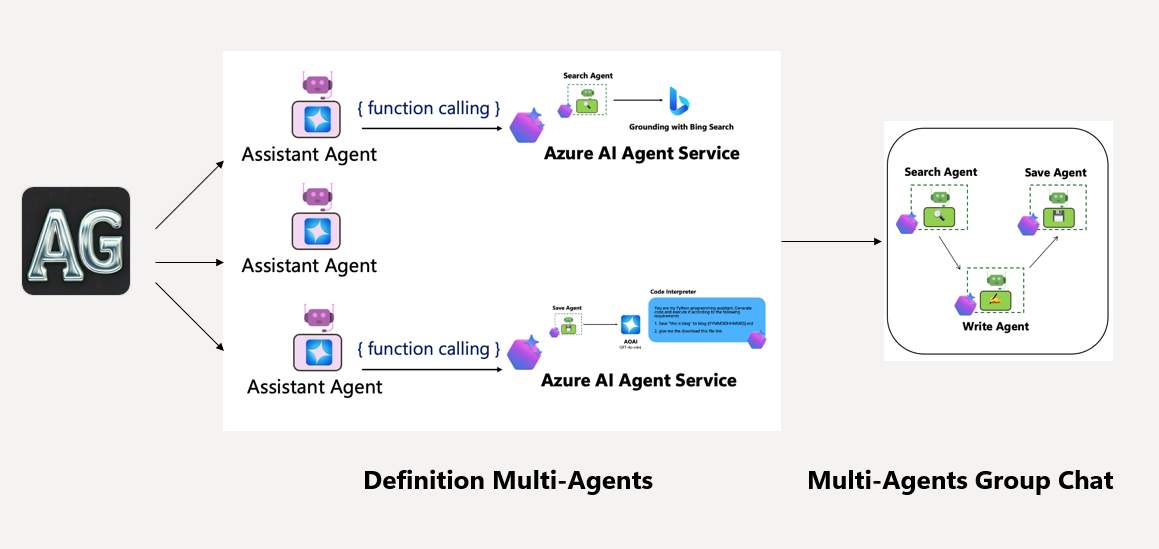


**Prerequisites**

1. Create an Azure Cosmos DB for MongoDB vCore resource (follow this quick start guide https://learn.microsoft.com/en-us/azure/cosmos-db/mongodb/vcore/quickstart-portal)
2. Azure AI foundry
3. Install libraries
4. Review single-agent architectures `01-single-agent-with-azure-ai-agents.ipynb` and Autogen Framework `03b-frameworks-intro-to-autogen-v2.ipynb`

In [7]:
#!pip install pymongo

**Initialize Project ai foundry**

In [63]:
# Import necessary libraries
import os
from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from utils.ml_logging import get_logger

logger = get_logger()

# Set your connection string (replace with your actual connection string)
project_connection_string = os.getenv("AZURE_AI_FOUNDRY_CONNECTION_STRING")

# Create the project client
project = AIProjectClient.from_connection_string(
    conn_str=project_connection_string, credential=DefaultAzureCredential()
)

# Verify connection
logger.info("AI Foundry project client created successfully")

2025-02-05 13:38:20,220 - INFO - No environment configuration found.
2025-02-05 13:38:20,222 - INFO - ManagedIdentityCredential will use IMDS
2025-02-05 13:38:20,226 - micro - MainProcess - INFO     AI Foundry project client created successfully (3305489847.py:<module>:19)
2025-02-05 13:38:20,226 - INFO - AI Foundry project client created successfully


**Retrieve an existent azure ai agent**

In [64]:
from tabulate import tabulate


def list_agents():
    """
    Extracts agent details along with the names of the tools,
    and prints the information as a table.
    """
    # list the agents created
    agents = project.agents.list_agents()
    # Prepare table headers.
    table_headers = ["ID", "Name", "Model", "Created At", "Owner"]
    table_rows = []

    # Loop over each agent entry.
    for agent in agents.get("data", []):
        agent_id = agent.get("id", "N/A")
        name = agent.get("name", "N/A")
        model = agent.get("model", "N/A")
        created_at = agent.get("created_at", "N/A")
        owner = agent.get("metadata", {}).get("owner", "N/A")
        table_rows.append([agent_id, name, model, created_at, owner])

    # Print the table using tabulate.
    print(tabulate(table_rows, headers=table_headers, tablefmt="grid"))

In [65]:
list_agents()

2025-02-05 13:38:26,111 - INFO - Request URL: 'http://169.254.169.254/metadata/identity/oauth2/token?api-version=REDACTED&resource=REDACTED'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.19.0 Python/3.10.15 (Windows-10-10.0.26100-SP0)'
No body was attached to the request
2025-02-05 13:38:29,995 - INFO - DefaultAzureCredential acquired a token from AzureCliCredential
2025-02-05 13:38:29,998 - INFO - Request URL: 'https://eastus.api.azureml.ms/agents/v1.0/subscriptions/20c54e6d-27f8-4aeb-8127-3dfa557b9721/resourceGroups/dev-rg-ai-factory/providers/Microsoft.MachineLearningServices/workspaces/agentic-lab-eastus-dev/assistants?api-version=REDACTED'
Request method: 'GET'
Request headers:
    'Accept': 'application/json'
    'x-ms-client-request-id': 'c49279bc-e3f8-11ef-a54e-00155d014400'
    'User-Agent': 'azsdk-python-ai-projects/1.0.0b5 Python/3.10.15 (Windows-10-10.0.26100-SP0)'
    'Authorization': 'REDACTED'
No body was attached to the request
2025-0

+-------------------------------+---------------------------+---------+--------------+-------------+
| ID                            | Name                      | Model   |   Created At | Owner       |
+===============================+===========================+=========+==============+=============+
| asst_maEkh96QlQYEuRKroDtgrYXd | evaluator-retriever-agent | gpt-4o  |   1738781783 | ai_coe_team |
+-------------------------------+---------------------------+---------+--------------+-------------+
| asst_DB74KdzJ2xS8ymetjFjmCI7z | mongodb-retreiver-agent   | gpt-4o  |   1738781764 | ai_coe_team |
+-------------------------------+---------------------------+---------+--------------+-------------+
| asst_g5MueSf6ax0rCgb1AoEgjh2v | evaluator-retriever-agent | gpt-4o  |   1738781500 | ai_coe_team |
+-------------------------------+---------------------------+---------+--------------+-------------+
| asst_RJIIW9szISe8OSuEMXu6d1hg | mongodb-retreiver-agent   | gpt-4o  |   1738781478 | ai_c

In [67]:
# load an agent
agent = project.agents.get_agent(assistant_id="asst_HbTLJnpIZ2AqQNyc62ZvnPTA")

2025-02-05 13:38:42,049 - INFO - Request URL: 'https://eastus.api.azureml.ms/agents/v1.0/subscriptions/20c54e6d-27f8-4aeb-8127-3dfa557b9721/resourceGroups/dev-rg-ai-factory/providers/Microsoft.MachineLearningServices/workspaces/agentic-lab-eastus-dev/assistants/asst_HbTLJnpIZ2AqQNyc62ZvnPTA?api-version=REDACTED'
Request method: 'GET'
Request headers:
    'Accept': 'application/json'
    'x-ms-client-request-id': 'ce129bc9-e3f8-11ef-a9d9-00155d014400'
    'User-Agent': 'azsdk-python-ai-projects/1.0.0b5 Python/3.10.15 (Windows-10-10.0.26100-SP0)'
    'Authorization': 'REDACTED'
No body was attached to the request
2025-02-05 13:38:43,247 - INFO - Response status: 200
Response headers:
    'Date': 'Wed, 05 Feb 2025 19:38:43 GMT'
    'Content-Type': 'application/json'
    'Transfer-Encoding': 'chunked'
    'Connection': 'keep-alive'
    'Vary': 'REDACTED'
    'Request-Context': 'REDACTED'
    'x-ms-response-type': 'REDACTED'
    'x-ms-middleware-request-id': 'REDACTED'
    'openai-version':

**Create Single Agent**

In [68]:
import os
import json
import logging
from typing import Optional, List, Dict, Any
from azure.core.exceptions import HttpResponseError


def create_azure_ai_agent(
    project,
    deployment_name: Optional[str] = None,
    name: str = "my-basic-agent",
    description: str = "Basic agent for technology support",
    instructions: str = "You are a friendly assistant who loves answering technology questions.",
    tools: Optional[List[Any]] = None,
    tool_resources: Optional[Any] = None,
    toolset: Optional[Any] = None,
    temperature: Optional[float] = None,
    top_p: Optional[float] = None,
    response_format: Optional[Any] = None,
    metadata: Optional[Dict[str, str]] = None,
    content_type: str = "application/json",
    **kwargs: Any,
):
    """
    Creates a basic AI agent using the provided project instance and extended parameters.

    Signature details for project.agents.create_agent:
      - model: str, the deployment model name (if not provided, it is retrieved from an environment variable)
      - name: Optional[str], the agent's name
      - description: Optional[str], a brief description of the agent
      - instructions: Optional[str], specific instructions that define the agent's behavior
      - tools: Optional[List[ToolDefinition]], tool definitions available to the agent
      - tool_resources: Optional[ToolResources], configuration for tool resources
      - toolset: Optional[ToolSet], a collection of tools available for the agent
      - temperature: Optional[float], controls the creativity of the agent's responses
      - top_p: Optional[float], controls the nucleus sampling for generating responses
      - response_format: Optional, the expected format of the agent's responses
      - metadata: Optional[Dict[str, str]], metadata associated with the agent
      - content_type: str, the content type for the request (default: 'application/json')
      - **kwargs: Any additional keyword arguments

    Args:
        project: An initialized AI project client with an `agents.create_agent` method.
        deployment_name (Optional[str]): The deployment model name. If not provided, the environment variable
                                         'AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID' will be used.
        name (str): The name of the agent.
        description (str): A description for the agent.
        instructions (str): Instructions that guide the agent's behavior.
        tools (Optional[List[Any]]): A list of tool definitions for the agent.
        tool_resources (Optional[Any]): Configuration for the agent's tool resources.
        toolset (Optional[Any]): A set of tools for the agent.
        temperature (Optional[float]): Controls response creativity.
        top_p (Optional[float]): Controls nucleus sampling.
        response_format (Optional[Any]): Specifies the desired response format.
        metadata (Optional[Dict[str, str]]): Metadata for the agent.
        content_type (str): The content type of the request.
        **kwargs: Any additional keyword arguments.

    Returns:
        The created agent instance if successful.

    Raises:
        SystemExit: If the deployment model name is missing or agent creation fails.
    """
    if not deployment_name:
        deployment_name = os.environ.get("AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID")
        if not deployment_name:
            logger.error(
                "Environment variable 'AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID' is not set."
            )
            exit(1)

    if metadata is None:
        metadata = {"owner": "IT Support"}

    try:
        agent = project.agents.create_agent(
            model=deployment_name,
            name=name,
            description=description,
            instructions=instructions,
            tools=tools,
            tool_resources=tool_resources,
            toolset=toolset,
            temperature=temperature,
            top_p=top_p,
            response_format=response_format,
            metadata=metadata,
            content_type=content_type,
            **kwargs,
        )
        logger.info(f"Created Agent ID: {agent.id}")
        logger.info(f"Agent Metadata: {agent.metadata}")
        return agent

    except HttpResponseError as e:
        error_content = e.response.content
        try:
            error_json = json.loads(error_content)
            logger.error(f"Error Message: {error_json.get('Message')}")
        except json.JSONDecodeError:
            logger.error(f"Non-JSON Error Content: {error_content}")
        exit(1)

### Creating Retriever Agent

In [69]:
import os
import logging
from azure.ai.projects.models import FunctionTool, ToolSet
from azure.ai.projects.models import MessageTextContent, MessageRole
from src.tools.mongodb_retriever import vector_search, retrieve_document

# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# --- Create a FunctionTool with custom MongoDB functions ---
functions_tool = FunctionTool(
    {
        vector_search,
    }
)
logger.info("FunctionTool with custom functions created.")

# --- Create a ToolSet and add the FunctionTool ---
my_toolset = ToolSet()
my_toolset.add(functions_tool)
logger.info("ToolSet created and FunctionTool added.")

# --- Create the agent with the custom ToolSet ---
retriever_agent = create_azure_ai_agent(
    project=project,  # project should be an already initialized AI project client instance
    deployment_name=os.environ.get("AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID"),
    name="mongodb-retreiver-agent",
    description="Agent for retrieving documents from MongoDB using vector search and custom query functions.",
    instructions="Leverage the provided tools to perform vector searches, query, retrieve, and delete operations in Cosmos DB MongoDB Core.",
    metadata={"owner": "ai_coe_team"},
    toolset=my_toolset,
)
logger.info(f"Agent created successfully with ID: {agent.id}")

2025-02-05 13:38:52,002 - INFO - FunctionTool with custom functions created.
2025-02-05 13:38:52,006 - INFO - ToolSet created and FunctionTool added.
2025-02-05 13:38:52,011 - INFO - Request URL: 'https://eastus.api.azureml.ms/agents/v1.0/subscriptions/20c54e6d-27f8-4aeb-8127-3dfa557b9721/resourceGroups/dev-rg-ai-factory/providers/Microsoft.MachineLearningServices/workspaces/agentic-lab-eastus-dev/assistants?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '667'
    'Accept': 'application/json'
    'x-ms-client-request-id': 'd402953c-e3f8-11ef-a21a-00155d014400'
    'User-Agent': 'azsdk-python-ai-projects/1.0.0b5 Python/3.10.15 (Windows-10-10.0.26100-SP0)'
    'Authorization': 'REDACTED'
A body is sent with the request
2025-02-05 13:38:52,723 - INFO - Response status: 200
Response headers:
    'Date': 'Wed, 05 Feb 2025 19:38:52 GMT'
    'Content-Type': 'application/json'
    'Transfer-Encoding': 'chunked'
    'Co

**Let's test the retriever Agent**

In [81]:
async def run_agent_conversation(agent, query):
    """
    Creates a conversation thread, sends a user message, and processes the run
    for the given agent (by its ID).
    """
    try:
        # 1. Create a new conversation thread.
        thread = project.agents.create_thread()
        logging.info(f"[Agent {agent.id}] Created Thread: {thread.id}")

        # 2. Create a user message in the thread.
        user_msg = project.agents.create_message(
            thread_id=thread.id,
            role=MessageRole.USER,
            content=query,  # The query can be customized per agent
        )
        logging.info(f"[Agent {agent.id}] Created user message ID: {user_msg.id}")

        # 3. Create and process the run using this agent's ID.
        run = project.agents.create_and_process_run(
            thread_id=thread.id, assistant_id=agent.id
        )
        logging.info(f"[Agent {agent.id}] Run finished with status: {run.status}")

        # 4. If run failed, clean up.
        if run.status == "failed":
            logging.error(f"[Agent {agent.id}] Run failed.")

        # 5. Retrieve and log the conversation messages.
        all_messages = project.agents.list_messages(thread_id=thread.id)
        logging.info(f"\n----- Conversation for Agent {agent.id} -----")
        for msg in reversed(all_messages.data):
            if len(msg.content) and isinstance(msg.content[-1], MessageTextContent):
                logging.info(f"{msg.role.upper()}: {msg.content[-1].text.value}")

        messages = project.agents.list_messages(thread_id=thread.id)
        return messages["data"][0]["content"][0]["text"]["value"]

    except Exception as e:
        logger.error(f"Failed to create and process run: {e}")

In [82]:
response = await run_agent_conversation(
    retriever_agent, query="What is covered under the PerksPlus program?"
)

2025-02-05 13:44:40,181 - INFO - Request URL: 'https://eastus.api.azureml.ms/agents/v1.0/subscriptions/20c54e6d-27f8-4aeb-8127-3dfa557b9721/resourceGroups/dev-rg-ai-factory/providers/Microsoft.MachineLearningServices/workspaces/agentic-lab-eastus-dev/threads?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '2'
    'Accept': 'application/json'
    'x-ms-client-request-id': 'a3890212-e3f9-11ef-8237-00155d014400'
    'User-Agent': 'azsdk-python-ai-projects/1.0.0b5 Python/3.10.15 (Windows-10-10.0.26100-SP0)'
    'Authorization': 'REDACTED'
A body is sent with the request
2025-02-05 13:44:42,266 - INFO - Response status: 200
Response headers:
    'Date': 'Wed, 05 Feb 2025 19:44:42 GMT'
    'Content-Type': 'application/json'
    'Content-Length': '137'
    'Connection': 'keep-alive'
    'Request-Context': 'REDACTED'
    'x-ms-response-type': 'REDACTED'
    'x-ms-middleware-request-id': 'REDACTED'
    'openai-version': 

In [83]:
print(response)

The PerksPlus program offers coverage for:

- Gym memberships
- Yoga
- Outdoor sports


Great, it worked! Retirever Agent was able to call the tool (Mongo Db) and performs an action (vector search) to return and retrieve the most similar responses based on the user's query similarity (cosine distance).


## Creating Evaluator Agent 

In [84]:
import os
import logging
from azure.ai.projects.models import FunctionTool, ToolSet
from azure.ai.projects.models import MessageTextContent, MessageRole
from src.tools.azure_ai_search_retriever import (
    semantic_search,
    keyword_search,
    hybrid_search,
)

# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# --- Create a FunctionTool with custom MongoDB functions ---
azure_search_functions_tool = FunctionTool(
    {
        semantic_search,
        keyword_search,
        hybrid_search,
    }
)
logger.info("FunctionTool with custom functions created.")

azure_search_toolset = ToolSet()
azure_search_toolset.add(azure_search_functions_tool)

evaluator_agent = create_azure_ai_agent(
    project=project,  # Initialized AI project client instance
    deployment_name=os.environ.get("AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID"),
    name="evaluator-retriever-agent-v2",
    description="Agent for evaluating MongoDB execution results using Azure AI Search as Ground Truth.",
    instructions="""You are the evaluation agent. Your role is to assess 
        the correctness of the MongoDB execution results using Azure AI Search  
        to verify the response content. Provide feedback, and if the result is correct, respond with "Approved".""",
    metadata={"owner": "ai_coe_team"},
    toolset=azure_search_toolset,
    headers={"x-ms-enable-preview": "true"},
)

logger.info(f"Evaluator agent created successfully with ID: {evaluator_agent.id}")

2025-02-05 13:45:42,693 - INFO - FunctionTool with custom functions created.
2025-02-05 13:45:42,700 - INFO - Request URL: 'https://eastus.api.azureml.ms/agents/v1.0/subscriptions/20c54e6d-27f8-4aeb-8127-3dfa557b9721/resourceGroups/dev-rg-ai-factory/providers/Microsoft.MachineLearningServices/workspaces/agentic-lab-eastus-dev/assistants?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '1721'
    'x-ms-enable-preview': 'REDACTED'
    'Accept': 'application/json'
    'x-ms-client-request-id': 'c8ccb086-e3f9-11ef-8488-00155d014400'
    'User-Agent': 'azsdk-python-ai-projects/1.0.0b5 Python/3.10.15 (Windows-10-10.0.26100-SP0)'
    'Authorization': 'REDACTED'
A body is sent with the request
2025-02-05 13:45:43,239 - INFO - Response status: 200
Response headers:
    'Date': 'Wed, 05 Feb 2025 19:45:43 GMT'
    'Content-Type': 'application/json'
    'Transfer-Encoding': 'chunked'
    'Connection': 'keep-alive'
    'Vary'

In [85]:
response = await run_agent_conversation(
    evaluator_agent,
    query="""Search the query if `The PerksPlus program covers 
                                  gym memberships, yoga, and outdoor sports.` is correct base on your knowledge base""",
)

2025-02-05 13:45:46,821 - INFO - Request URL: 'https://eastus.api.azureml.ms/agents/v1.0/subscriptions/20c54e6d-27f8-4aeb-8127-3dfa557b9721/resourceGroups/dev-rg-ai-factory/providers/Microsoft.MachineLearningServices/workspaces/agentic-lab-eastus-dev/threads?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '2'
    'Accept': 'application/json'
    'x-ms-client-request-id': 'cb418e64-e3f9-11ef-804c-00155d014400'
    'User-Agent': 'azsdk-python-ai-projects/1.0.0b5 Python/3.10.15 (Windows-10-10.0.26100-SP0)'
    'Authorization': 'REDACTED'
A body is sent with the request
2025-02-05 13:45:47,276 - INFO - Response status: 200
Response headers:
    'Date': 'Wed, 05 Feb 2025 19:45:47 GMT'
    'Content-Type': 'application/json'
    'Content-Length': '137'
    'Connection': 'keep-alive'
    'Request-Context': 'REDACTED'
    'x-ms-response-type': 'REDACTED'
    'x-ms-middleware-request-id': 'REDACTED'
    'openai-version': 

In [86]:
print(response)

Approved


In [89]:
import os
from dotenv import load_dotenv

# autogen_agentchat and related libraries
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console

# Azure OpenAI Chat Client
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient

# Create the Azure OpenAI client
# Ensure these environment variables are set:
#   AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID
#   AZURE_OPENAI_KEY
#   AZURE_OPENAI_API_ENDPOINT
model_client = AzureOpenAIChatCompletionClient(
    model=os.getenv("AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID"),
    azure_deployment=os.getenv("AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID"),
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_API_ENDPOINT"),
    api_version=os.getenv("AZURE_API_VERSION", "2024-06-01"),
    seed=42,
    temperature=0,
)

evaluator_agent = project.agents.get_agent(assistant_id="asst_SeN5SzRLv1UIaa0pPdh6xX8T")
mongo_execution_agent = project.agents.get_agent(
    assistant_id="asst_HbTLJnpIZ2AqQNyc62ZvnPTA"
)

###############################################
# Tools Section: define how each agent performs its tasks
###############################################
# Replace placeholder functions with your actual implementations or integrations.
# Here we assume that run_agent_conversation exists to invoke a tool conversation.


async def mongo_task_tool(query: str) -> str:
    """Tool for querying the enterprise MongoDB cluster."""
    # This would typically call your MongoDB retrieval routines.
    # For illustration, we simulate a conversation with the evaluator agent.
    return await run_agent_conversation(mongo_execution_agent, query=query)


async def azure_search_evaluator_tool(query: str) -> str:
    """Tool for verifying content correctness via the agent's knowledge base and Azure AI Search."""
    # In this revised version, the evaluator agent will use its internal knowledge
    # (and optionally Azure AI Search functions) to validate the content.
    return await run_agent_conversation(evaluator_agent, query=query)


###############################################
# Instantiate the Agents
###############################################
# 1) Mongo Execution Agent: retrieves and returns data from MongoDB.
mongo_execution_agent = AssistantAgent(
    name="mongo_execution_agent",
    model_client=model_client,
    system_message=(
        "You are the execution agent. Your job is to pick up the user’s intent and query MongoDB. "
        "If needed, record or update relevant data in the database. Return the query results in plain text."
    ),
    tools=[mongo_task_tool],
)

# 2) Evaluation Agent: checks the execution agent's results using its knowledge base.
evaluation_agent = AssistantAgent(
    name="evaluation_agent",
    model_client=model_client,
    system_message=(
        "You are the evaluation agent. Your role is to check the previous agent's results using your knowledge base "
        "and, if available, Azure AI Search to verify the content. If everything is correct, respond with 'Approved'. "
        "If not, request clarification or correction."
    ),
    tools=[azure_search_evaluator_tool],
)

###############################################
# Orchestration: Round-Robin Chat
###############################################
# The conversation will terminate when either the evaluation agent outputs "Approved"
# or after 5 messages.
termination = TextMentionTermination("Approved") | MaxMessageTermination(5)
reflection_team = RoundRobinGroupChat(
    [mongo_execution_agent, evaluation_agent], termination_condition=termination
)


###############################################
# Run the Multi-Agent Workflow
###############################################
async def run_main_scenario_1():
    """
    In this example, the user wants to know: "What is covered under the PerksPlus program?"
    1) The first agent (mongo_execution_agent) attempts to retrieve the data.
    2) The second agent (evaluation_agent) verifies the correctness of the result using its knowledge base
       (and optionally Azure AI Search).
    The conversation stops when the response "Approved" is reached or after 5 messages.
    """
    await Console(
        reflection_team.run_stream(
            task="""
            I want to execute the following task: "What is covered under the PerksPlus program?"
            Once the task is executed, evaluate the result using your knowledge base and Azure AI Search tools.
            Provide feedback with the final result in JSON format following this schema:
            ```json
            {
                "response": "If correct, the coverage details. If not correct, 'N/A'"
            }
            ```
        """
        )
    )

2025-02-05 13:47:49,068 - INFO - Request URL: 'https://eastus.api.azureml.ms/agents/v1.0/subscriptions/20c54e6d-27f8-4aeb-8127-3dfa557b9721/resourceGroups/dev-rg-ai-factory/providers/Microsoft.MachineLearningServices/workspaces/agentic-lab-eastus-dev/assistants/asst_SeN5SzRLv1UIaa0pPdh6xX8T?api-version=REDACTED'
Request method: 'GET'
Request headers:
    'Accept': 'application/json'
    'x-ms-client-request-id': '141f1255-e3fa-11ef-b145-00155d014400'
    'User-Agent': 'azsdk-python-ai-projects/1.0.0b5 Python/3.10.15 (Windows-10-10.0.26100-SP0)'
    'Authorization': 'REDACTED'
No body was attached to the request
2025-02-05 13:47:49,561 - INFO - Response status: 200
Response headers:
    'Date': 'Wed, 05 Feb 2025 19:47:49 GMT'
    'Content-Type': 'application/json'
    'Transfer-Encoding': 'chunked'
    'Connection': 'keep-alive'
    'Vary': 'REDACTED'
    'Request-Context': 'REDACTED'
    'x-ms-response-type': 'REDACTED'
    'x-ms-middleware-request-id': 'REDACTED'
    'openai-version':

In [90]:
await run_main_scenario_1()

2025-02-05 13:47:54,597 - INFO - {"payload": "{\"messages\":[{\"source\":\"user\",\"models_usage\":null,\"content\":\"\\n            I want to execute the following task: \\\"What is covered under the PerksPlus program?\\\"\\n            Once the task is executed, evaluate the result using your knowledge base and Azure AI Search tools.\\n            Provide feedback with the final result in JSON format following this schema:\\n            ```json\\n            {\\n                \\\"response\\\": \\\"If correct, the coverage details. If not correct, 'N/A'\\\"\\n            }\\n            ```\\n        \",\"type\":\"TextMessage\"}]}", "sender": null, "receiver": "group_chat_manager/c803e5c8-720f-468b-98ed-a3a5c640c40d", "kind": "MessageKind.DIRECT", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
2025-02-05 13:47:54,601 - INFO - Sending message of type GroupChatStart to group_chat_manager: {'messages': [TextMessage(source='user', models_usage=None, content='\n            I 

---------- user ----------

            I want to execute the following task: "What is covered under the PerksPlus program?"
            Once the task is executed, evaluate the result using your knowledge base and Azure AI Search tools.
            Provide feedback with the final result in JSON format following this schema:
            ```json
            {
                "response": "If correct, the coverage details. If not correct, 'N/A'"
            }
            ```
        


2025-02-05 13:47:55,989 - INFO - HTTP Request: POST https://pablo-m2aomhoo-australiaeast.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-06-01 "HTTP/1.1 200 OK"
2025-02-05 13:47:55,992 - INFO - {"type": "LLMCall", "messages": [{"content": "You are the execution agent. Your job is to pick up the user\u2019s intent and query MongoDB. If needed, record or update relevant data in the database. Return the query results in plain text.", "role": "system"}, {"content": "\n            I want to execute the following task: \"What is covered under the PerksPlus program?\"\n            Once the task is executed, evaluate the result using your knowledge base and Azure AI Search tools.\n            Provide feedback with the final result in JSON format following this schema:\n            ```json\n            {\n                \"response\": \"If correct, the coverage details. If not correct, 'N/A'\"\n            }\n            ```\n        ", "role": "user", "name": "user

---------- mongo_execution_agent ----------
[FunctionCall(id='call_fzWQ3t1iknXNMZ0FMBdwc5Xn', arguments='{"query":"What is covered under the PerksPlus program?"}', name='mongo_task_tool')]
---------- mongo_execution_agent ----------
[FunctionExecutionResult(content='None', call_id='call_fzWQ3t1iknXNMZ0FMBdwc5Xn')]
---------- mongo_execution_agent ----------
None


2025-02-05 13:47:57,089 - INFO - HTTP Request: POST https://pablo-m2aomhoo-australiaeast.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-06-01 "HTTP/1.1 200 OK"
2025-02-05 13:47:57,095 - INFO - {"type": "LLMCall", "messages": [{"content": "You are the evaluation agent. Your role is to check the previous agent's results using your knowledge base and, if available, Azure AI Search to verify the content. If everything is correct, respond with 'Approved'. If not, request clarification or correction.", "role": "system"}, {"content": "\n            I want to execute the following task: \"What is covered under the PerksPlus program?\"\n            Once the task is executed, evaluate the result using your knowledge base and Azure AI Search tools.\n            Provide feedback with the final result in JSON format following this schema:\n            ```json\n            {\n                \"response\": \"If correct, the coverage details. If not correct, 'N/A'\"\n    

---------- evaluation_agent ----------
[FunctionCall(id='call_PfMctBuQkwktjD3uDofxrTXR', arguments='{"query":"What is covered under the PerksPlus program?"}', name='azure_search_evaluator_tool')]
---------- evaluation_agent ----------
[FunctionExecutionResult(content='The PerksPlus program covers a wide range of fitness activities, including but not limited to:\n\n1. Gym memberships\n2. Personal training sessions\n3. Yoga and Pilates classes\n4. Fitness equipment purchases\n5. Sports team fees\n6. Health retreats and spas\n7. Outdoor adventure activities (such as rock climbing, hiking, and kayaking)\n\nApproved', call_id='call_PfMctBuQkwktjD3uDofxrTXR')]
---------- evaluation_agent ----------
The PerksPlus program covers a wide range of fitness activities, including but not limited to:

1. Gym memberships
2. Personal training sessions
3. Yoga and Pilates classes
4. Fitness equipment purchases
5. Sports team fees
6. Health retreats and spas
7. Outdoor adventure activities (such as rock 

### **2. How-to create MaS with SK (Agentic Framework) + Azure AI Agent Service (Managed Agents)**

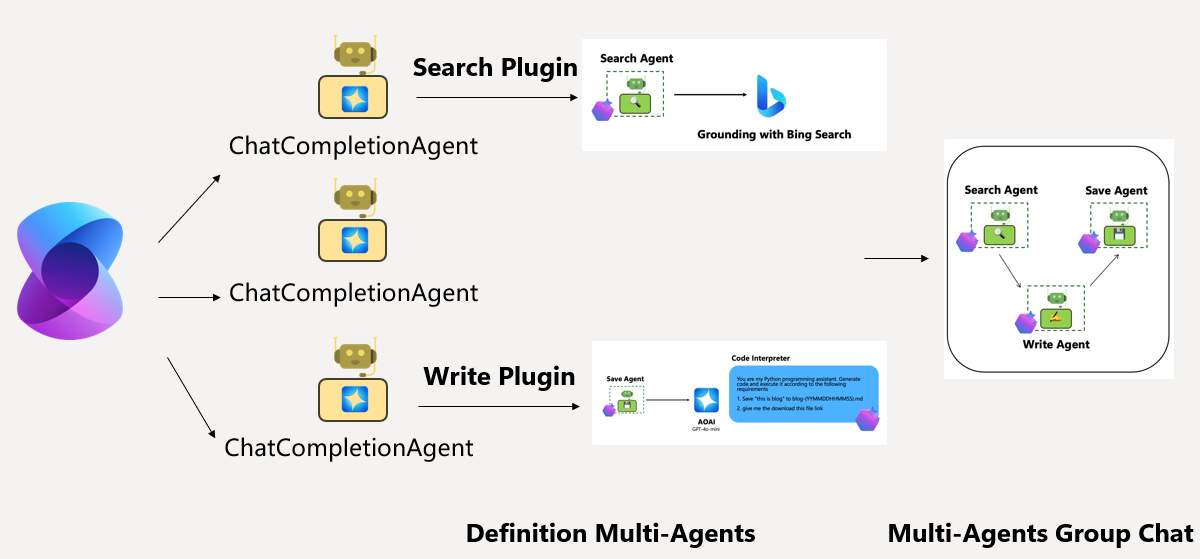